# 极速 Agent - 快速构建 SQL Agent！

<img src="./assets/LC_L1_top.png" align="left" width="500">

## 设置

加载并/或检查所需的环境变量

In [3]:
from dotenv import load_dotenv

# 从 .env 加载环境变量
load_dotenv()


True

In [4]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

定义运行时上下文，为代理和工具提供数据库访问。

In [5]:
from dataclasses import dataclass
from langchain_community.utilities import SQLDatabase

# 定义上下文结构以支持依赖注入
@dataclass
class RuntimeContext:
    """运行时上下文，保存数据库连接供代理和工具使用。"""
    db: SQLDatabase

<b>⚠️ 安全提示：</b> 此演示未对 LLM 生成的命令进行过滤。在生产环境中，你应当限制 LLM 生成命令的范围。⚠️   
该工具将连接数据库，注意使用 `get_runtime` 访问图的**运行时上下文**。

In [6]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)  # 取出运行时上下文
    db = runtime.context.db              # 获取数据库连接

    try:
        return db.run(query)#进行数据库查询
    except Exception as e:
        return f"Error: {e}"

添加系统提示语以定义代理的行为。

In [7]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

你是一名谨慎的 SQLite 分析员。

规则：

按步骤思考。
需要数据时，使用工具 execute_sql 发起「单条」SELECT 查询。
只读：不允许 INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE。
输出默认限制 5 行，除非用户明确要求更多。
如果工具返回 “Error:”，请修改 SQL 再试。
优先写明列名，避免使用 SELECT *。

In [11]:
from langchain_qwq import ChatQwen
import os
llm=ChatQwen(
    model="qwen3-max",
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
    api_key=os.getenv("DASHSCOPE_API_KEY")
)
llm.invoke("你好")

AIMessage(content='你好！很高兴见到你，有什么我可以帮忙的吗？😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 9, 'total_tokens': 22, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'dashscope', 'model_name': 'qwen3-max', 'system_fingerprint': None, 'id': 'chatcmpl-6ee7059d-87ec-4861-9712-b2a9d01826b9', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--9ebe3248-73a9-4e71-9e0a-31f46c6be40a-0', usage_metadata={'input_tokens': 9, 'output_tokens': 13, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})

创建你的代理！添加模型、工具、提示语以及运行时访问，然后即可运行！你可以从我们的[集成](https://docs.langchain.com/oss/python/integrations/providers)列表中选择多种代理。

In [8]:
from langchain.agents import create_agent

agent = create_agent(
    model=llm,
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

下面展示代理的 ReAct 循环。

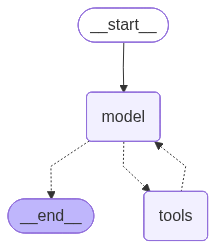

In [9]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

运行一些查询，注意：
- 代理并不知道数据库 schema，需要自行探索。
- 代理可能会犯错！通过返回的错误信息，它可以自我纠正查询。
- 注意你是使用 `agent.stream` 调用代理的。
    - 这个命令与 `pretty_print` 会展示模型与工具之间传递的**消息**。
- 注意代理在不同调用之间不会记住 schema……稍后再讲！

In [13]:
question = "Which table has the largest number of entries?"
#哪张表的条目数量最多？
for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    #step["messages"][-1].pretty_print()
    print(step["messages"][-1])

content='Which table has the largest number of entries?' additional_kwargs={} response_metadata={} id='6b44766d-6682-49bc-8dda-2d2b3de68561'
content="I'll determine which table has the largest number of entries by checking the row count for each table in the database.\n\nFirst, I need to identify all the tables in the database.\n\n" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 360, 'total_tokens': 425, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'dashscope', 'model_name': 'qwen3-max', 'system_fingerprint': None, 'id': 'chatcmpl-a7f29bef-13f1-4bd6-a240-ec745a3c6d4c', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--a06a3ab0-9b5e-4197-b4b1-1d8289748ed1-0' tool_calls=[{'name': 'execute_sql', 'args': {'query': "SELECT name FROM sqlite_master WHERE type='table';"}, 'id': 'call_6ce6e777f4444472836681f4', 'type': 'tool_call'}] usage_met

In [14]:
question = "Which table has the largest number of entries?"
#哪张表的条目数量最多？
for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()
    #print(step["messages"][-1])

================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================

I'll determine which table has the largest number of entries by checking the row count for each table in the database.

First, I need to identify all the tables in the database.
Tool Calls:
  execute_sql (call_5f43f992680f4ceabf0aac77)
 Call ID: call_5f43f992680f4ceabf0aac77
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

Now I'll check the row count for each table to determine which has the largest number of entries.


### 第一步：用户提问 (Human Message)

> **原文：** Which table has the largest number of entries?
> **翻译：** 哪个表的数据条目（行数）最多？

**解读：** 用户提出了一个自然语言问题。AI 此时只知道你要找“最大的表”，但它还不知道数据库里到底有哪些表。

-----

### 第二步：AI 思考与第一次行动 (AI Message)

**AI 的内心独白（推理）：**

> **原文：** I'll help you find which table has the largest number of entries. First, I need to identify all the tables in the database, and then count the rows in each table. Let me start by getting the list of tables...
> **翻译：** 我来帮你找哪个表条目最多。首先，我需要**识别数据库里所有的表**，然后再统计每个表的行数。让我先从获取表单列表开始……

**AI 的行动（调用工具）：**

> **工具名称：** `execute_sql` (执行 SQL)
> **生成的 SQL：** `SELECT name FROM sqlite_master WHERE type='table';`

**专业解读：**
AI 非常聪明。它知道不能直接 `SELECT *`，它需要先看“地图”。在 SQLite 数据库中，`sqlite_master` 是系统表，存着所有表的元数据。AI 决定先查这张表来搞清楚“这里有哪些数据表”。

-----

### 第三步：工具反馈 (Tool Message)

**工具执行结果：**

> **原文：** `[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]`

**解读：** 数据库告诉 AI：“我有 Album（专辑）、Artist（歌手）... 等等这 11 张表。”
此时，AI 的“短期记忆”里就有了这份列表。

-----

### 第四步：AI 思考与第二次行动 (AI Message)

**AI 的内心独白（推理）：**

> **原文：** Now I'll count the number of entries in each table to find which one has the largest number. Let me check each table...
> **翻译：** 现在我要统计每张表的条目数，找出最大的那个。让我来检查每一张表……

**AI 的行动（调用工具）：**

> **工具名称：** `execute_sql`
> **生成的 SQL：**
>
> ```sql
> SELECT 'Album' as table_name, COUNT(*) as row_count FROM Album
> UNION ALL
> SELECT 'Artist' as table_name, COUNT(*) as row_count FROM Artist
> ... (省略中间部分) ...
> SELECT 'Track' as table_name, COUNT(*) as row_count FROM Track
> ORDER BY row_count DESC
> LIMIT 1;
> ```

**专业解读（高光时刻）：**
这是这个 Agent 最精彩的地方！

1.  它没有笨笨地分 11 次去查数据库（那样会产生 11 次网络交互，很慢）。
2.  它利用 LLM 的逻辑能力，直接写了一个巨大的 **`UNION ALL`** 查询。它把 11 张表的 `COUNT(*)` 拼在一起。
3.  它还加上了 `ORDER BY row_count DESC LIMIT 1`（按行数降序排列，只取第一个）。
    这说明 AI 懂 SQL 优化，它想一步到位直接拿到“第一名”。

-----

### 第五步：工具反馈 (Tool Message)

**工具执行结果：**

> **原文：** `[('PlaylistTrack', 8715)]`

**解读：** 数据库运行了那条复杂的 SQL，直接返回了冠军：`PlaylistTrack` 表，有 8715 行。

-----

### 第六步：最终回答 (AI Message)

**AI 回复用户：**

> **原文：** The table with the largest number of entries is **PlaylistTrack** with **8,715** rows.
> **翻译：** 条目数量最多的表是 **PlaylistTrack**，共有 **8,715** 行。



In [15]:
question = "Which genre on average has the longest tracks?"
#哪个流派的曲目平均时长最长？
for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================

To determine which genre has the longest tracks on average, I'll need to:

1. Identify the relevant tables that contain track length (duration) and genre information.
2. Join these tables if necessary.
3. Compute the average track length per genre.
4. Find the genre with the highest average.

First, let's explore the database schema to understand the table structure.
Tool Calls:
  execute_sql (call_84c3c5984fa04152b89694c7)
 Call ID: call_84c3c5984fa04152b89694c7
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), 

In [10]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_l1UWwgSfPDbtNMgiOqdd1QHf)
 Call ID: call_l1UWwgSfPDbtNMgiOqdd1QHf
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_XVZ2quL9z2LYrw1gb6jknw5L)
 Call ID: call_XVZ2quL9z2LYrw1gb6jknw5L
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('

**在这里创建你自己的查询！** 添加你自己的问题。

In [ ]:
question = "TRY YOUR OWN QUERY HERE"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

### 让我们试试这个 Studio